In [1]:
import os
# use this in google colab
"""os.environ['KAGGLE_CONFIG_DIR'] = '/content/'"""

In [2]:
# use this in google colab
"""! chmod 600 /content/kaggle.json"""

chmod: cannot access '/content/kaggle.json': No such file or directory


### **Importing_Libraries**

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import glob
import os

from keras import Input
from keras.applications import VGG19
from keras.callbacks import TensorBoard
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense
from keras.layers import Conv2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import random
from numpy import asarray
from itertools import repeat

import imageio
from imageio import imread
from PIL import Image
from skimage.transform import resize as imresize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import pathlib


print("Tensorflow version " + tf.__version__)

Tensorflow version 2.14.0


In [4]:
! pip install visualkeras







     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 18.0 MB/s eta 0:00:00




In [5]:
import visualkeras

### **Loading_Data**

In [6]:
# use this in google colab
"""! kaggle datasets download -d paultimothymooney/kermany2018"""



100% 10.8G/10.8G [09:18<00:00, 23.2MB/s]

100% 10.8G/10.8G [09:18<00:00, 20.8MB/s]


In [7]:
# use this in google colab
""""import zipfile


zip_file_path = "/content/kermany2018.zip"
extracted_dir = "/content/kermany2018"


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

print("Dataset has been extracted to:", extracted_dir)""""


Dataset has been extracted to: /content/kermany2018


In [8]:
train_directory = '/content/kermany2018/OCT2017 /train'
test_directory = '/content/kermany2018/OCT2017 /test'

In [9]:
val_directory = '/content/kermany2018/OCT2017 /val'

### **Preprocessing**

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
main_path = pathlib.Path("/content/kermany2018/OCT2017 ")
train_path = main_path / 'train'
test_path = main_path / 'test'
val_path = main_path / 'val'

In [ ]:
import random
train_image_paths = [str(path) for path in list(train_path.glob('*/*.jpeg'))]
random.shuffle(train_image_paths)
test_image_paths = [str(path) for path in list(test_path.glob('*/*.jpeg'))]
val_image_paths = [str(path) for path in list(val_path.glob('*/*.jpeg'))]


print('Number of training images:', len(train_image_paths))
print('Number of testing images:', len(test_image_paths))
print('Number of validation images:', len(val_image_paths))


Number of training images: 83484

Number of testing images: 968

Number of validation images: 32


In [ ]:
# directory = Path(train_directory)
label_names = sorted(set(item.name for item in train_path.glob('*') if item.is_dir()))
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

In [ ]:
import random
train_image_paths = [str(path) for path in list(train_path.glob('*/*.jpeg'))]
random.shuffle(train_image_paths)
test_image_paths = [str(path) for path in list(test_path.glob('*/*.jpeg'))]
val_image_paths = [str(path) for path in list(val_path.glob('*/*.jpeg'))]


print('Number of training images:', len(train_image_paths))
print('Number of testing images:', len(test_image_paths))
print('Number of validation images:', len(val_image_paths))

Number of training images: 83484

Number of testing images: 968

Number of validation images: 32


In [ ]:
train_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in train_image_paths]
test_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in test_image_paths]
val_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in val_image_paths]

print("First 10 labels indices: ", train_image_labels[:10])

First 10 labels indices:  [0, 1, 1, 0, 1, 0, 0, 0, 3, 0]


In [ ]:
test = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    image_size=(192,192),
    batch_size=64,
    color_mode='rgb',
)

Found 968 files belonging to 4 classes.


In [ ]:
target_im_size = [192, 192]

def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize_image_with_crop_or_pad(image, 496, 496)
    image = tf.image.resize_images(image, target_im_size)
    image /= 255.0
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=1, expand_animations=False)
    image = tf.image.resize(image, [192, 192])
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

In [ ]:
# Path datasets
train_path_ds = tf.data.Dataset.from_tensor_slices(train_image_paths)
test_path_ds = tf.data.Dataset.from_tensor_slices(test_image_paths)
val_path_ds = tf.data.Dataset.from_tensor_slices(val_image_paths)

# Image datasets
train_image_ds = train_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
test_image_ds = test_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
val_image_ds = val_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

# Label datasets
train_label_ds = tf.data.Dataset.from_tensor_slices(train_image_labels)
test_label_ds = tf.data.Dataset.from_tensor_slices(test_image_labels)
val_label_ds = tf.data.Dataset.from_tensor_slices(val_image_labels)

# Zip datasets
train_image_label_ds = tf.data.Dataset.zip((train_image_ds, train_label_ds))
test_image_label_ds = tf.data.Dataset.zip((test_image_ds, test_label_ds))
val_image_label_ds = tf.data.Dataset.zip((val_image_ds, val_label_ds))


In [ ]:
example_element = next(iter(train_image_label_ds))

# Extract image and label
example_image, example_label = example_element

# Check the shape and type of the image and label
print('image shape: ', example_image[0].shape)
print('image type: ', example_image[0].dtype)
print('label shape: ', example_label.shape)
print('label type: ', example_label.dtype)

image shape:  (192, 1)

image type:  <dtype: 'float32'>

label shape:  ()

label type:  <dtype: 'int32'>


In [ ]:
image_shape = train_image_label_ds.element_spec[0].shape
image_type = train_image_label_ds.element_spec[0].dtype

label_shape = train_image_label_ds.element_spec[1].shape
label_type = train_image_label_ds.element_spec[1].dtype

print('image shape: ', image_shape)
print('image type: ', image_type)
print('label shape: ', label_shape)
print('label type: ', label_type)

image shape:  (192, 192, 1)

image type:  <dtype: 'float32'>

label shape:  ()

label type:  <dtype: 'int32'>


In [ ]:
BATCH_SIZE = 64

train_ds = train_image_label_ds.shuffle(buffer_size=400) # Shuffles datasets
train_ds = train_ds.repeat() # Creates datasets iterator
train_ds = train_ds.batch(BATCH_SIZE) # Batches dataset
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE) # Allows dataset to prefetch batches while training for performance

# Repeat for testing dataset
test_ds = test_image_label_ds.shuffle(buffer_size=200)
test_ds = test_ds.repeat()
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Repeat for validation dataset
val_ds = val_image_label_ds.shuffle(buffer_size=200)
val_ds = val_ds.repeat()
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

> ## **Model 1 **

In [ ]:
model = Sequential()

model.add(Conv2D(64, (5, 5), padding='valid', activation='relu', input_shape=(*target_im_size, 1))) # CNN Layer 1
model.add(MaxPooling2D((2, 2))) # Pooling layer 1

model.add(Conv2D(64, (5, 5), activation='relu')) # CNN Layer 2
model.add(MaxPooling2D((2, 2))) # Pooling layer 2

model.add(Conv2D(128, (5, 5), activation='relu')) # CNN Layer 3
model.add(Flatten()) # Flattening layer

model.add(Dense(128, activation='relu')) # Fully-connected layer "on top"
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax')) # Softmax output from logits

In [ ]:
model.summary()


Model: "sequential_5"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_19 (Conv2D)          (None, 188, 188, 64)      1664      

                                                                 

 max_pooling2d_10 (MaxPooli  (None, 94, 94, 64)        0         

 ng2D)                                                           

                                                                 

 conv2d_20 (Conv2D)          (None, 90, 90, 64)        102464    

                                                                 

 max_pooling2d_11 (MaxPooli  (None, 45, 45, 64)        0         

 ng2D)                                                           

                                                                 

 conv2d_21 (Conv2D)          (None, 41, 41, 128)       204928    

                                                                 

 flatten_5 (Flatten)         (None, 21

In [ ]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',

             metrics=['accuracy'])


In [ ]:
checkpoint_dir = '/content/training_checkpoints'

os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
validation_metrics = ['accuracy', 'loss']

In [ ]:
EPOCHS = 15
history = model.fit(train_ds, epochs=EPOCHS, steps_per_epoch=len(train_image_paths)//BATCH_SIZE, callbacks=[checkpoint_callback])

Epoch 1/15

1304/1304 [==============================] - 132s 100ms/step - loss: 2.7937 - accuracy: 0.4559

Epoch 2/15

1304/1304 [==============================] - 130s 100ms/step - loss: 1.2233 - accuracy: 0.4577

Epoch 3/15

1304/1304 [==============================] - 130s 99ms/step - loss: 1.2315 - accuracy: 0.4576

Epoch 4/15

1304/1304 [==============================] - 129s 99ms/step - loss: 1.2311 - accuracy: 0.4455

Epoch 5/15

1304/1304 [==============================] - 129s 99ms/step - loss: 1.2311 - accuracy: 0.4457

Epoch 6/15

1304/1304 [==============================] - 129s 99ms/step - loss: 1.2469 - accuracy: 0.4454

Epoch 7/15

1304/1304 [==============================] - 128s 98ms/step - loss: 1.2317 - accuracy: 0.4456

Epoch 8/15

1304/1304 [==============================] - 128s 98ms/step - loss: 1.2323 - accuracy: 0.4459

Epoch 9/15

1304/1304 [==============================] - 128s 98ms/step - loss: 1.2299 - accuracy: 0.4454

Epoch 10/15

1304/1304 [===========

In [ ]:
test_loss, test_acc = model.evaluate(test_ds, steps=len(test_image_paths))

968/968 [==============================] - 28s 28ms/step - loss: 1.5534 - accuracy: 0.2500


In [ ]:
predictions = model.predict(test_ds, steps=len(test_image_paths))#Convert prediction probabilities into integers
predictions = np.argmax(predictions, axis=1)

968/968 [==============================] - 26s 27ms/step


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
test_labels = [labels for _, labels in test.unbatch()]

In [ ]:
true_labels = []
predicted_labels = []

# Iterate through the dataset and collect true labels and predictions
for data, labels in test_ds:
    true_labels.extend(labels)
    predictions = model.predict(data)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [ ]:
!pip install joblib

In [ ]:
import joblib
model_filename = 'my_model.pkl'

# Save the model to the PKL file
joblib.dump(model, model_filename)

['my_model.pkl']

In [ ]:
model.save("/content/my_model")

# Or, save it in the Keras HDF5 format
model.save("/content/my_model.h5")

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("/content/my_model.h5")

In [ ]:
predictions1 = loaded_model.predict(test_ds, steps=len(test_image_paths))

968/968 [==============================] - 26s 27ms/step


In [ ]:
# Convert the test_image_ds dataset to a list
test_image_list = list(test_image_ds.as_numpy_iterator())

# Find the true predicted images and their paths
true_predicted_images = []
true_predicted_paths = []

for i, prediction in enumerate(predictions):
    # Get the class with the highest probability
    predicted_class = np.argmax(prediction)

    # Get the true class label for this image
    true_class = test_image_labels[i]

    if predicted_class == true_class:
        # If the prediction is correct, store the image and its path
        true_predicted_images.append(test_image_list[i])  # Access the list instead of the dataset
        true_predicted_paths.append(test_image_paths[i])


In [ ]:
true_predicted_paths

['/content/kermany2018/OCT2017 /test/NORMAL/NORMAL-3277704-1.jpeg',
 '/content/kermany2018/OCT2017 /test/NORMAL/NORMAL-1989796-1.jpeg',
 '/content/kermany2018/OCT2017 /test/NORMAL/NORMAL-3220509-1.jpeg',
 '/content/kermany2018/OCT2017 /test/NORMAL/NORMAL-2075832-1.jpeg',
 '/content/kermany2018/OCT2017 /test/NORMAL/NORMAL-395557-1.jpeg',
 '/content/kermany2018/OCT2017 /test/NORMAL/NORMAL-36734-1.jpeg',
 '/content/kermany2018/OCT2017 /test/NORMAL/NORMAL-3561306-2.jpeg',
 '/content/kermany2018/OCT2017 /test/NORMAL/NORMAL-1038998-1.jpeg',
 '/content/kermany2018/OCT2017 /test/NORMAL/NORMAL-628048-1.jpeg',
 '/content/kermany2018/OCT2017 /test/NORMAL/NORMAL-574089-1.jpeg',
 '/content/kermany2018/OCT2017 /test/NORMAL/NORMAL-1073137-1.jpeg',
 '/content/kermany2018/OCT2017 /test/NORMAL/NORMAL-571157-1.jpeg',
 '/content/kermany2018/OCT2017 /test/NORMAL/NORMAL-655447-1.jpeg',
 '/content/kermany2018/OCT2017 /test/NORMAL/NORMAL-2158556-1.jpeg',
 '/content/kermany2018/OCT2017 /test/NORMAL/NORMAL-2011

In [ ]:
! pip install rarfile
! pip install patool




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.1 MB/s eta 0:00:00




### **2nd_Preprocessing**

In [11]:
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [12]:
BATCH_SIZE = 64

In [13]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    seed=0,
    image_size=(192,192),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    validation_split= 0.2,
    subset='training'
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    seed=0,
    image_size=(192,192),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    validation_split=0.2,
    subset='validation'
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    image_size=(192,192),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
)

Found 83484 files belonging to 4 classes.

Using 66788 files for training.

Found 83484 files belonging to 4 classes.

Using 16696 files for validation.

Found 968 files belonging to 4 classes.


In [14]:
test_labels = [labels for _, labels in test.unbatch()]

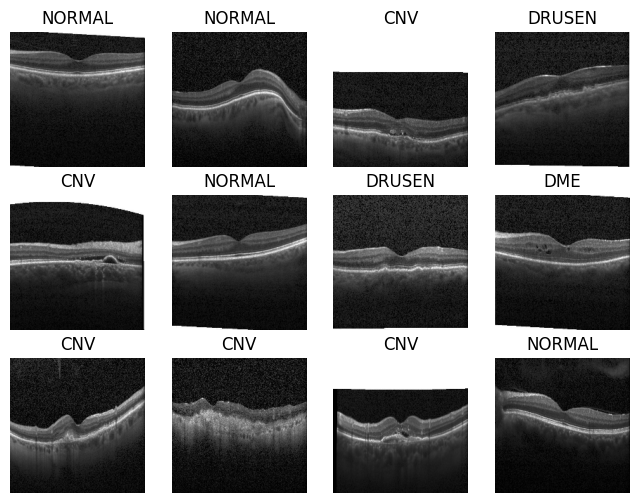

In [15]:
class_names=train.class_names
plt.figure(figsize=(8, 6))
for images, labels in train.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
BATCH_SIZE = BATCH_SIZE
class_names = train.class_names

def class_distribution(dataset):
    class_values = []
    total_batches = dataset.__len__().numpy()
    for batch, element in enumerate(dataset.as_numpy_iterator()):
        if batch+1 == total_batches:
            for i in range(len(element[1])):
                class_values.append(class_names[int(element[1][i])])
        else:
            for i in range(BATCH_SIZE):
                class_values.append(class_names[int(element[1][i])])

    class_n, frequency = np.unique(np.array(class_values), return_counts=True)
    #frequency = frequency/len(class_values)
    return pd.DataFrame(frequency, class_n, columns=["Count"])

train_class_dist = class_distribution(train)
print(train_class_dist)

        Count

CNV     29709

DME      9113

DRUSEN   6917

NORMAL  21049


In [17]:
total = len(train.file_paths)
count_cnv = 29709
count_dme = 9113
count_drusen = 6917
count_normal = 21049
cnv_weight = (1/count_cnv) * (total/4)
dme_weight = (1/count_dme) * (total/4)
drusen_weight = (1/count_drusen) * (total/4)
norm_weight = (1/count_normal) * (total/4)
class_weight = {0 : cnv_weight, 1: dme_weight, 2 : drusen_weight, 3: norm_weight}
print(class_weight)

{0: 0.5620182436298764, 1: 1.8322177109623616, 2: 2.413907763481278, 3: 0.7932443346477267}


In [18]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
train = (
    train
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
validation = (
    validation
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
test = (
    test
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

### **Model_2_**

In [ ]:
model2 = Sequential()

model2.add(Conv2D(64, (3, 3), padding='valid', activation='relu', input_shape=(192,192,3))) # CNN Layer 1
model2.add(MaxPooling2D((2, 2))) # Pooling layer 1

model2.add(Conv2D(128, (3, 3), activation='relu')) # CNN Layer 2
model2.add(MaxPooling2D((2, 2))) # Pooling layer 2

model2.add(Conv2D(128, (5, 5), activation='relu')) # CNN Layer 3
model2.add(Conv2D(128, (5, 5), activation='relu')) # CNN Layer 4
model2.add(Flatten()) # Flattening layer

model2.add(Dense(256, activation='relu')) # Fully-connected layer "on top"
model2.add(Dropout(0.2))

model2.add(Dense(4, activation='softmax')) # Softmax output from logits

In [ ]:
model2.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 190, 190, 64)      1792      

                                                                 

 max_pooling2d (MaxPooling2  (None, 95, 95, 64)        0         

 D)                                                              

                                                                 

 conv2d_1 (Conv2D)           (None, 93, 93, 128)       73856     

                                                                 

 max_pooling2d_1 (MaxPoolin  (None, 46, 46, 128)       0         

 g2D)                                                            

                                                                 

 conv2d_2 (Conv2D)           (None, 42, 42, 128)       409728    

                                                                 

 conv2d_3 (Conv2D)           (None, 38, 

In [ ]:
model2.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',

             metrics=['accuracy'])

In [ ]:

# Directory where the checkpoints will be saved
checkpoint_dir = '/content/training_checkpoints2'

# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# ModelCheckpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
validation_metrics = ['accuracy', 'loss']

In [ ]:
EPOCHS = 25
history = model2.fit(train, validation_data=validation, epochs=EPOCHS,  callbacks=[checkpoint_callback], shuffle=True)

Epoch 1/25

  51/1044 [>.............................] - ETA: 2:25 - loss: 1.2319 - accuracy: 0.4412

KeyboardInterrupt: ignored

In [ ]:
model_filename = 'my_model2.pkl'


joblib.dump(model2, model_filename)

In [ ]:
model2.save("/content/my_model")

model2.save("/content/my_model.h5")

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(),
              history_df['val_accuracy'].max()))

In [ ]:
model2.evaluate(test, return_dict=True)

In [ ]:
predictions = model2.predict(test)
#Convert prediction probabilities into integers
predictions = np.argmax(predictions, axis=1)

In [ ]:
class_labels= ['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [ ]:
print(classification_report(predictions, test_labels, target_names=class_labels))

### **Model_3_**

In [ ]:
model3 = Sequential()

model3.add(Conv2D(64, (3, 3), padding='valid', activation='relu', input_shape=(192, 192, 3)))
model3.add(MaxPooling2D((2, 2)))
model3.add(BatchNormalization())  # Batch normalization layer

model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(BatchNormalization())  # Batch normalization layer

model3.add(Conv2D(128, (5, 5), activation='relu'))
model3.add(Conv2D(128, (5, 5), activation='relu'))
model3.add(Flatten())

model3.add(Dense(256, activation='relu'))
model3.add(BatchNormalization())  # Batch normalization layer
model3.add(Dropout(0.5))

model3.add(Dense(4, activation='softmax'))

In [ ]:
model3.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',

             metrics=['accuracy'])

In [ ]:
EPOCHS = 25
history2 = model3.fit(train, validation_data=validation, epochs=EPOCHS,  callbacks=[checkpoint_callback], shuffle=True)

Epoch 1/25

1044/1044 [==============================] - 215s 189ms/step - loss: 0.5524 - accuracy: 0.7997 - val_loss: 0.3913 - val_accuracy: 0.8534

Epoch 2/25

1044/1044 [==============================] - 194s 186ms/step - loss: 0.3254 - accuracy: 0.8882 - val_loss: 0.6773 - val_accuracy: 0.8031

Epoch 3/25

1044/1044 [==============================] - 195s 187ms/step - loss: 0.2663 - accuracy: 0.9112 - val_loss: 0.2738 - val_accuracy: 0.9088

Epoch 4/25

1044/1044 [==============================] - 194s 186ms/step - loss: 0.2111 - accuracy: 0.9299 - val_loss: 0.5060 - val_accuracy: 0.8447

Epoch 5/25

1044/1044 [==============================] - 194s 186ms/step - loss: 0.1836 - accuracy: 0.9402 - val_loss: 0.8284 - val_accuracy: 0.8255

Epoch 6/25

1044/1044 [==============================] - 194s 185ms/step - loss: 0.2450 - accuracy: 0.9194 - val_loss: 0.2312 - val_accuracy: 0.9227

Epoch 7/25

1044/1044 [==============================] - 193s 185ms/step - loss: 0.1517 - accuracy: 

In [ ]:
model_filename = 'my_model3.pkl'

joblib.dump(model3, model_filename)

['my_model3.pkl']

In [ ]:
model3.save("/content/my3_model.h5")

In [ ]:
! pip install visualkeras







     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 6.0 MB/s eta 0:00:00




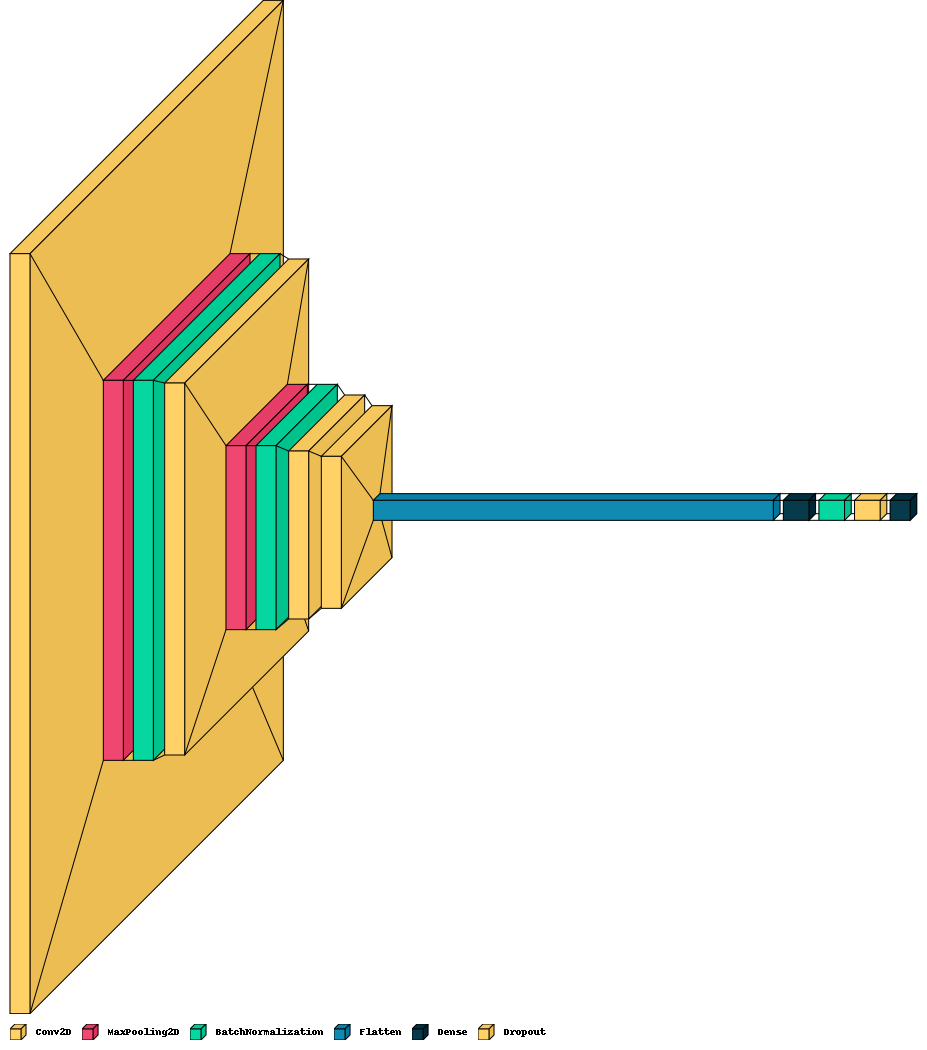

In [ ]:
import visualkeras
visualkeras.layered_view(model3, legend=True)

Best Validation Loss: 0.1542

Best Validation Accuracy: 0.9490


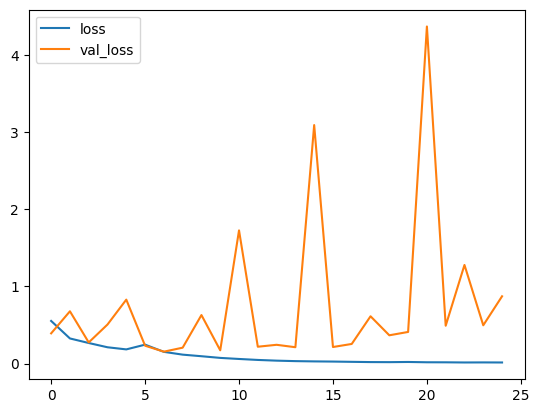

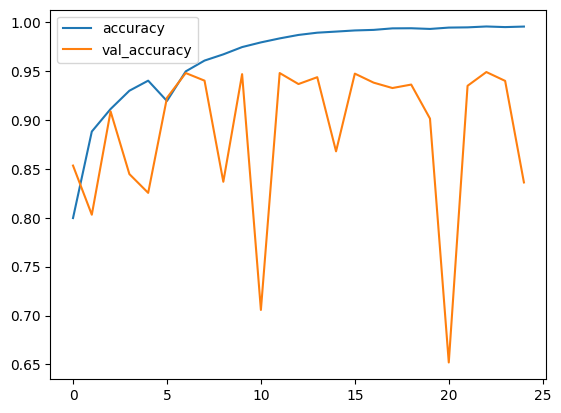

In [ ]:
history_df = pd.DataFrame(history2.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(),
              history_df['val_accuracy'].max()))

In [ ]:
import os

# Specify the directory path where you want to save the model
save_directory = '/content/drive/My Drive/Your_Desired_Folder/'

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Now save the model to the correct path
model_filename = os.path.join(save_directory, 'my_model3.pkl')
joblib.dump(model3, model_filename)

['/content/drive/My Drive/Your_Desired_Folder/my_model3.pkl']

In [ ]:
model3.evaluate(test, return_dict=True)

16/16 [==============================] - 2s 73ms/step - loss: 0.3612 - accuracy: 0.9329


{'loss': 0.36118316650390625, 'accuracy': 0.932851254940033}

In [ ]:
test = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    image_size=(192, 192),
    batch_size=BATCH_SIZE,
    color_mode='rgb'
)

# Extract and store the file paths
test_file_paths = test.file_paths

Found 968 files belonging to 4 classes.


In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model("/content/my3_model.h5")

predictions = loaded_model.predict(test)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.array(test_labels)

correct_predictions = (predicted_labels == true_labels)

correctly_predicted_paths = [path for i, path in enumerate(test.file_paths) if correct_predictions[i]]

incorrectly_predicted_paths = [path for i, path in enumerate(test.file_paths) if not correct_predictions[i]]

16/16 [==============================] - 2s 50ms/step


In [ ]:
correctly_predicted_paths

['/content/kermany2018/OCT2017 /test/DRUSEN/DRUSEN-9049813-1.jpeg',
 '/content/kermany2018/OCT2017 /test/CNV/CNV-5594757-1.jpeg',
 '/content/kermany2018/OCT2017 /test/DRUSEN/DRUSEN-1237848-1.jpeg',
 '/content/kermany2018/OCT2017 /test/DME/DME-7585263-2.jpeg',
 '/content/kermany2018/OCT2017 /test/DME/DME-7585263-3.jpeg',
 '/content/kermany2018/OCT2017 /test/NORMAL/NORMAL-544457-1.jpeg',
 '/content/kermany2018/OCT2017 /test/DME/DME-30521-5.jpeg',
 '/content/kermany2018/OCT2017 /test/CNV/CNV-3241692-2.jpeg',
 '/content/kermany2018/OCT2017 /test/CNV/CNV-2141150-1.jpeg',
 '/content/kermany2018/OCT2017 /test/NORMAL/NORMAL-549356-1.jpeg',
 '/content/kermany2018/OCT2017 /test/CNV/CNV-5674369-4.jpeg',
 '/content/kermany2018/OCT2017 /test/DME/DME-8589279-1.jpeg',
 '/content/kermany2018/OCT2017 /test/NORMAL/NORMAL-2287992-1.jpeg',
 '/content/kermany2018/OCT2017 /test/DRUSEN/DRUSEN-364469-3.jpeg',
 '/content/kermany2018/OCT2017 /test/DME/DME-9211360-2.jpeg',
 '/content/kermany2018/OCT2017 /test/CN

In [ ]:
import shutil
import os

# Create directories for correctly and incorrectly predicted images
correct_dir = '/content/correctly_predicted_images'
incorrect_dir = '/content/incorrectly_predicted_images'

os.makedirs(correct_dir, exist_ok=True)
os.makedirs(incorrect_dir, exist_ok=True)

# Copy correctly and incorrectly predicted images to their respective directories
for path in correctly_predicted_paths:
    image_name = os.path.basename(path)
    shutil.copy(path, os.path.join(correct_dir, image_name))

for path in incorrectly_predicted_paths:
    image_name = os.path.basename(path)
    shutil.copy(path, os.path.join(incorrect_dir, image_name))

# Create zip files for correctly and incorrectly predicted images
shutil.make_archive('/content/correctly_predicted_images', 'zip', correct_dir)
shutil.make_archive('/content/incorrectly_predicted_images', 'zip', incorrect_dir)

'/content/incorrectly_predicted_images.zip'

### Model_4_

In [ ]:
model4 = Sequential()

model4.add(Conv2D(64, (3, 3), padding='valid', activation='relu', input_shape=(192, 192, 3)))
model4.add(MaxPooling2D((2, 2)))
model4.add(BatchNormalization())  # Batch normalization layer
model4.add(Dropout(0.2))

model4.add(Conv2D(128, (3, 3), activation='relu'))
model4.add(MaxPooling2D((2, 2)))
model4.add(BatchNormalization())  # Batch normalization layer

model4.add(Conv2D(128, (5, 5), activation='relu'))
model4.add(Conv2D(128, (5, 5), activation='relu'))
model4.add(Flatten())

model4.add(Dense(256, activation='relu'))
model4.add(BatchNormalization())  # Batch normalization layer
model4.add(Dropout(0.5))

model4.add(Dense(4, activation='softmax'))

In [ ]:
model4.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',

             metrics=['accuracy'])

In [ ]:
model4.summary()

Model: "sequential_4"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_15 (Conv2D)          (None, 190, 190, 64)      1792      

                                                                 

 max_pooling2d_8 (MaxPoolin  (None, 95, 95, 64)        0         

 g2D)                                                            

                                                                 

 batch_normalization_6 (Bat  (None, 95, 95, 64)        256       

 chNormalization)                                                

                                                                 

 dropout_4 (Dropout)         (None, 95, 95, 64)        0         

                                                                 

 conv2d_16 (Conv2D)          (None, 93, 93, 128)       73856     

                                                                 

 max_pooling2d_9 (MaxPoolin  (None, 46

In [ ]:
EPOCHS = 25
history3 = model4.fit(train, validation_data=validation, epochs=EPOCHS,  callbacks=[checkpoint_callback], shuffle=True)

Epoch 1/25

1044/1044 [==============================] - 322s 306ms/step - loss: 0.5739 - accuracy: 0.7933 - val_loss: 0.3996 - val_accuracy: 0.8713

Epoch 2/25

1044/1044 [==============================] - 314s 300ms/step - loss: 0.3649 - accuracy: 0.8732 - val_loss: 0.4660 - val_accuracy: 0.8389

Epoch 3/25

1044/1044 [==============================] - 312s 299ms/step - loss: 0.2498 - accuracy: 0.9147 - val_loss: 0.3201 - val_accuracy: 0.8917

Epoch 4/25

1044/1044 [==============================] - 308s 295ms/step - loss: 0.2499 - accuracy: 0.9168 - val_loss: 1.5976 - val_accuracy: 0.5955

Epoch 5/25

1044/1044 [==============================] - 314s 301ms/step - loss: 0.2006 - accuracy: 0.9328 - val_loss: 0.3155 - val_accuracy: 0.9041

Epoch 6/25

1044/1044 [==============================] - 314s 300ms/step - loss: 0.1601 - accuracy: 0.9454 - val_loss: 0.3497 - val_accuracy: 0.9097

Epoch 7/25

1044/1044 [==============================] - 312s 299ms/step - loss: 0.1552 - accuracy: 

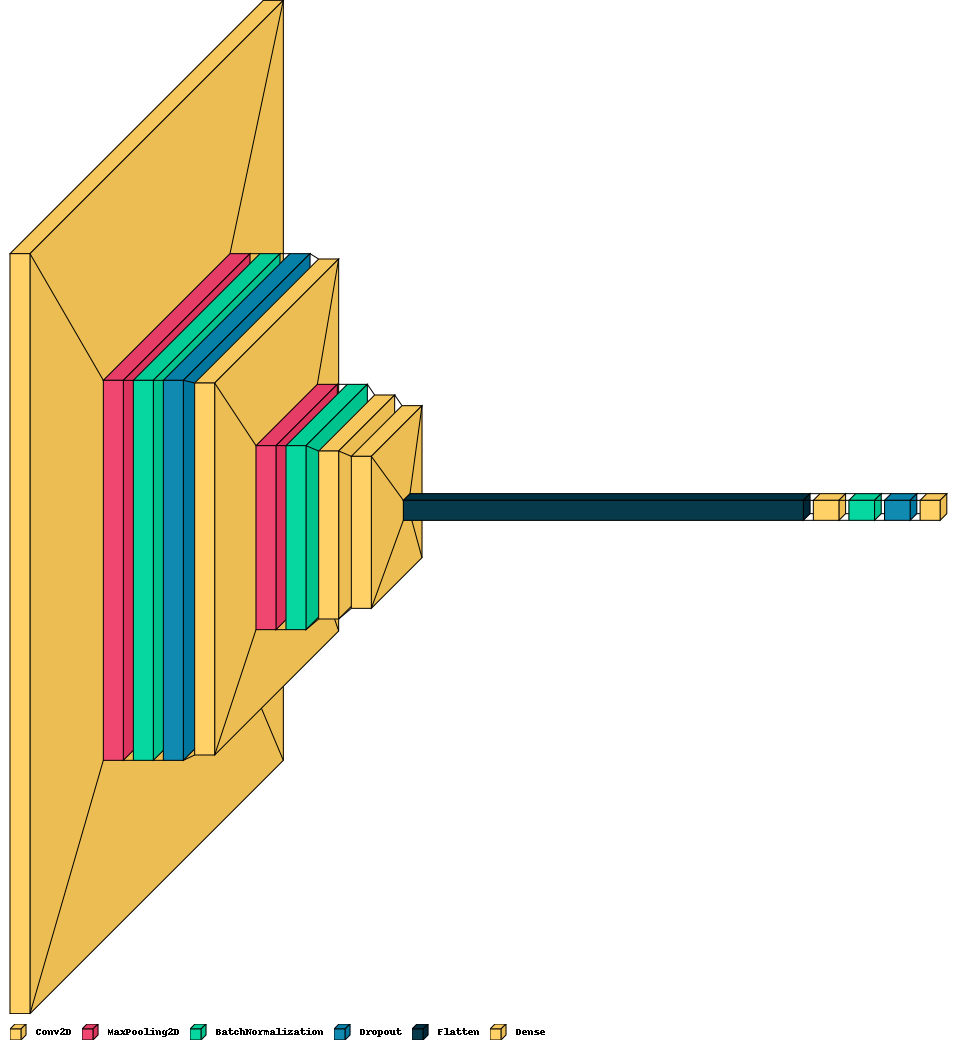

In [ ]:
visualkeras.layered_view(model4, legend=True)

In [ ]:
model4.evaluate(test, return_dict=True)

16/16 [==============================] - 1s 48ms/step - loss: 0.0622 - accuracy: 0.9814


{'loss': 0.06220165640115738, 'accuracy': 0.9814049601554871}

### **Model_5_**

In [20]:
model5 = Sequential()

model5.add(Conv2D(64, (3, 3), padding='valid', activation='relu', input_shape=(192, 192, 3)))
model5.add(MaxPooling2D((2, 2))) # Pooling layer 1


model5.add(Conv2D(64, (3, 3), activation='relu')) # CNN Layer 2
model5.add(MaxPooling2D((2, 2))) # Pooling layer 2
model5.add(BatchNormalization())  # Batch normalization layer
model5.add(Dropout(0.2))


model5.add(Conv2D(64, (3, 3), activation='relu')) # CNN Layer 3
model5.add(MaxPooling2D((2, 2))) # Pooling layer 3
model5.add(BatchNormalization())  # Batch normalization layer

model5.add(Conv2D(64, (3, 3), activation='relu')) # CNN Layer 3
model5.add(MaxPooling2D((2, 2))) # Pooling layer 3
model5.add(BatchNormalization())  # Batch normalization layer

model5.add(Conv2D(128, (3,3), activation='relu')) # CNN Layer 4
model5.add(Flatten()) # Flattening layer

model5.add(Dense(64, activation='relu')) # Fully-connected layer "on top"
model5.add(Dropout(0.2))

model5.add(Dense(4, activation='softmax')) # Softmax output from logits

In [21]:
model5.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [23]:
EPOCHS = 25
history4 = model5.fit(train, validation_data=validation, epochs=EPOCHS, shuffle=True)

Epoch 1/25

1044/1044 [==============================] - 222s 198ms/step - loss: 0.6058 - accuracy: 0.7774 - val_loss: 0.3936 - val_accuracy: 0.8588

Epoch 2/25

1044/1044 [==============================] - 182s 175ms/step - loss: 0.3173 - accuracy: 0.8914 - val_loss: 0.5957 - val_accuracy: 0.8464

Epoch 3/25

1044/1044 [==============================] - 181s 173ms/step - loss: 0.2311 - accuracy: 0.9227 - val_loss: 0.4717 - val_accuracy: 0.8460

Epoch 4/25

1044/1044 [==============================] - 180s 172ms/step - loss: 0.1827 - accuracy: 0.9396 - val_loss: 0.3890 - val_accuracy: 0.8594

Epoch 5/25

1044/1044 [==============================] - 177s 170ms/step - loss: 0.1534 - accuracy: 0.9490 - val_loss: 0.2098 - val_accuracy: 0.9380

Epoch 6/25

1044/1044 [==============================] - 177s 170ms/step - loss: 0.1314 - accuracy: 0.9549 - val_loss: 0.5789 - val_accuracy: 0.8047

Epoch 7/25

1044/1044 [==============================] - 177s 169ms/step - loss: 0.1161 - accuracy: 

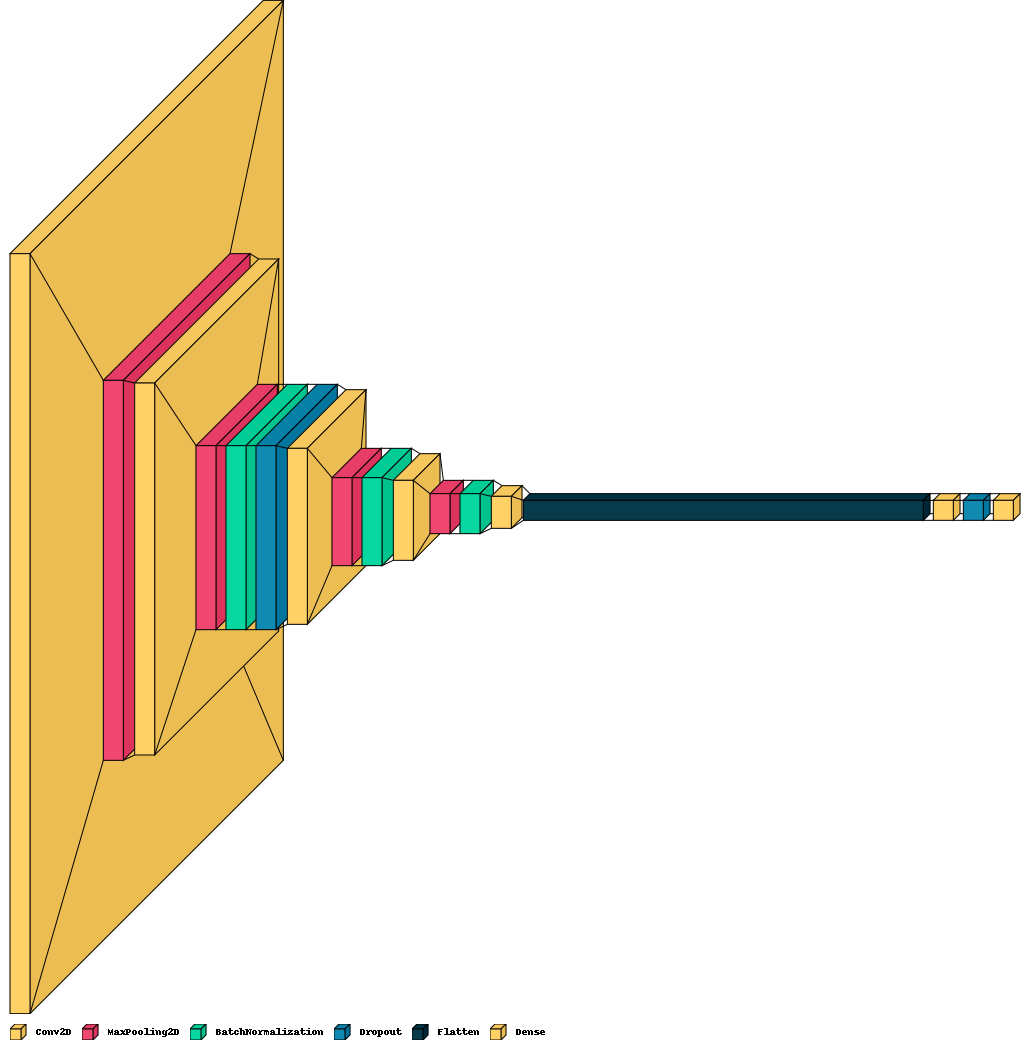

In [26]:
visualkeras.layered_view(model5, legend=True)

In [24]:
model5.evaluate(test, return_dict=True)

16/16 [==============================] - 2s 43ms/step - loss: 0.0278 - accuracy: 0.9897


{'loss': 0.02778383530676365, 'accuracy': 0.9896694421768188}

In [27]:
predictions = model5.predict(test)
#Convert prediction probabilities into integers
predictions = np.argmax(predictions, axis=1)

16/16 [==============================] - 1s 27ms/step


Best Validation Loss: 0.1789

Best Validation Accuracy: 0.9566


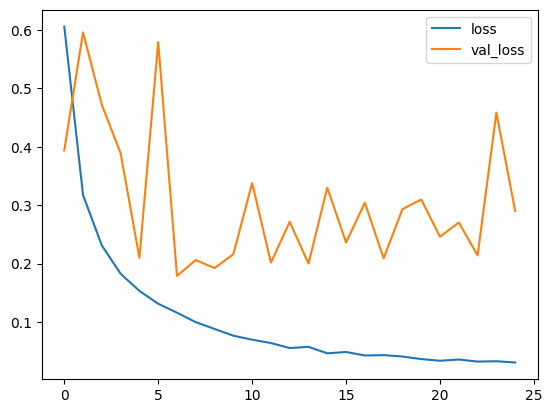

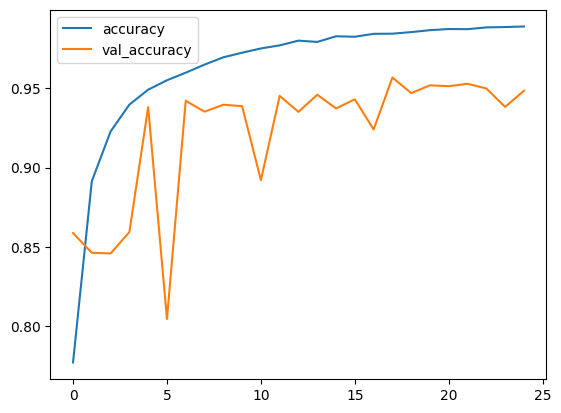

In [41]:
history_df = pd.DataFrame(history4.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(),
              history_df['val_accuracy'].max()))

In [40]:
model5.save("/content/my5_model.h5")

In [44]:
test = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    image_size=(192, 192),
    batch_size=BATCH_SIZE,
    color_mode='rgb'
)

# Extract and store the file paths
test_file_paths = test.file_paths

Found 968 files belonging to 4 classes.


In [45]:
from tensorflow.keras.models import load_model

loaded_model = load_model("/content/my5_model.h5")

predictions = loaded_model.predict(test)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.array(test_labels)

correct_predictions = (predicted_labels == true_labels)

correctly_predicted_paths = [path for i, path in enumerate(test.file_paths) if correct_predictions[i]]

incorrectly_predicted_paths = [path for i, path in enumerate(test.file_paths) if not correct_predictions[i]]

16/16 [==============================] - 1s 31ms/step


In [47]:
len(correctly_predicted_paths)

225

In [48]:
len(incorrectly_predicted_paths)

743

In [46]:
import shutil

# Create directories for correctly and incorrectly predicted images
correct_dir = '/content/correctly_predicted_images'
incorrect_dir = '/content/incorrectly_predicted_images'

os.makedirs(correct_dir, exist_ok=True)
os.makedirs(incorrect_dir, exist_ok=True)

# Copy correctly and incorrectly predicted images to their respective directories
for path in correctly_predicted_paths:
    image_name = os.path.basename(path)
    shutil.copy(path, os.path.join(correct_dir, image_name))

for path in incorrectly_predicted_paths:
    image_name = os.path.basename(path)
    shutil.copy(path, os.path.join(incorrect_dir, image_name))

# Create zip files for correctly and incorrectly predicted images
shutil.make_archive('/content/correctly_predicted_images', 'zip', correct_dir)
shutil.make_archive('/content/incorrectly_predicted_images', 'zip', incorrect_dir)

'/content/incorrectly_predicted_images.zip'